In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import pickle

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [33]:
from utils import find_nearest_index, align_pulse, split_pulses
from models.models_icp import ArtifactsDetectionModel, ResNet1D
from models.models_abp import ShallowResNet1D

In [34]:
icp_artifacts_model = ArtifactsDetectionModel()
icp_artifacts_model.load_state_dict(torch.load(Path(r'models\icp\artifacts.pt')))

icp_general_model = ResNet1D()
icp_general_model.load_state_dict(torch.load(Path(r'models\icp\general_class.pth')))

icp_subclass_0_1_model = ResNet1D()
icp_subclass_0_1_model.load_state_dict(torch.load(Path(r'models\icp\subclasses_t0_t1.pth')))

icp_subclass_2_3_4_model = ResNet1D(num_classes=3)
icp_subclass_2_3_4_model.load_state_dict(torch.load(Path(r'models\icp\subclasses_t2_t3_t4.pth')))

<All keys matched successfully>

In [35]:
abp_artifacts_model = ArtifactsDetectionModel(num_classes=2)
abp_artifacts_model.load_state_dict(torch.load(Path(r'models\abp\artifacts.pt')))

abp_general_model = ShallowResNet1D()
abp_general_model.load_state_dict(torch.load(Path(r'models\abp\general_class.pth')))

<All keys matched successfully>

In [36]:
def batched_predict(model, inputs, batch_size=1024, device='cuda'):
    model = model.to(device)
    model.eval()
    preds = []
    confs = []
    loader = DataLoader(TensorDataset(inputs), batch_size=batch_size)
    with torch.no_grad():
        for (batch,) in loader:
            batch = batch.to(device)
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)
            conf, pred = torch.max(probs, dim=1)
            preds.append(pred.cpu())
            confs.append(conf.cpu())
    return torch.cat(preds), torch.cat(confs)

def get_icp_class(waveforms, model_artifacts, model_general, model_subclass_normal, model_subclass_pathological,
    confidence_threshold=0.0, batch_size=1024, device='cuda'):

    waveforms = waveforms.to(dtype=torch.float32)
    final_preds = torch.full((waveforms.shape[0],), -2, dtype=torch.long)

    preds_valid, conf_valid = batched_predict(model_artifacts, waveforms, batch_size=batch_size, device=device)
    confident_valid_mask = conf_valid >= confidence_threshold
    artifact_mask = (preds_valid == 2) & (preds_valid == 1) & confident_valid_mask

    final_preds[artifact_mask] = -1
    valid_mask = ~artifact_mask

    preds_general, _ = batched_predict(model_general, waveforms)
    normal_mask = preds_general == 0
    pathological_mask = preds_general == 1

    preds_subclass_normal, _ = batched_predict(model_subclass_normal, waveforms)
    final_preds[valid_mask & normal_mask] = preds_subclass_normal[valid_mask & normal_mask]

    preds_subclass_pathological, _ = batched_predict(model_subclass_pathological, waveforms)
    final_preds[valid_mask & pathological_mask] = preds_subclass_pathological[valid_mask & pathological_mask] + 2

    return final_preds


def get_abp_class(waveforms, model_artifacts, model_general,
    confidence_threshold=0.0, batch_size=1024, device='cuda'):

    waveforms = waveforms.to(dtype=torch.float32)
    final_preds = torch.full((waveforms.shape[0],), -2, dtype=torch.long)

    preds_valid, conf_valid = batched_predict(model_artifacts, waveforms)
    confident_valid_mask = conf_valid >= confidence_threshold
    artifact_mask = (preds_valid == 1) & confident_valid_mask
    
    final_preds[artifact_mask] = -1
    valid_mask = ~artifact_mask

    preds_general, _ = batched_predict(model_general, waveforms)
    final_preds[valid_mask] = preds_general[valid_mask]

    return final_preds

In [37]:
def extract_pulses(time, signal, start_indices, end_indices, output_len=180, device='cpu'):
    if not isinstance(signal, torch.Tensor):
        signal = torch.tensor(signal, dtype=torch.float32)

    signal = signal.to(device)
    start_indices = torch.tensor(start_indices, dtype=torch.long, device=device)
    end_indices = torch.tensor(end_indices, dtype=torch.long, device=device)

    times = []
    waveforms = []
    for start, end in zip(start_indices, end_indices):
        t = time[start:end]
        pulse = signal[start:end]
        pulse = align_pulse(t, pulse)

        pulse = (pulse - pulse.min()) / (pulse.max() - pulse.min())

        pulse = pulse.unsqueeze(0).unsqueeze(0)
        resampled = F.interpolate(pulse, size=output_len, mode='linear', align_corners=False)

        waveforms.append(resampled.squeeze(0))
        times.append(t[0])

    return torch.stack(waveforms, dim=0), times

In [41]:
file_path = Path(r'd:\Data\Preludium\Preludium_release\PAC03_FULL_SIGNALS.pkl')

with open(file_path, 'rb') as f:
    data = pickle.load(f)
    t = data['t']
    icp = data['icp']
    abp = data['abp']
    fs = data['fs_hat']

start_time = t[0]
end_idx = find_nearest_index(t, start_time + 2 * 60 * 60)

t = t[:end_idx]
icp = icp[:end_idx]
abp = abp[:end_idx]

_, _, pulse_onsets_icp = split_pulses(icp, t, fs)
_, _, pulse_onsets_abp = split_pulses(abp, t, fs)

pulse_starts_icp = pulse_onsets_icp[:-1]
pulse_ends_icp = pulse_onsets_icp[1:]
pulses_icp, times_icp = extract_pulses(t, icp, pulse_starts_icp, pulse_ends_icp)

pulse_starts_abp = pulse_onsets_abp[:-1]
pulse_ends_abp = pulse_onsets_abp[1:]
pulses_abp, times_abp = extract_pulses(t, abp, pulse_starts_abp, pulse_ends_abp)

predictions_icp = get_icp_class(pulses_icp, icp_artifacts_model, icp_general_model, icp_subclass_0_1_model, icp_subclass_2_3_4_model)
predictions_icp = predictions_icp.detach().cpu().numpy()

predictions_abp = get_abp_class(pulses_abp, abp_artifacts_model, abp_general_model)
predictions_abp = predictions_abp.detach().cpu().numpy()

In [42]:
print(np.unique(predictions_icp, return_counts=True))

(array([0, 1, 2, 3, 4], dtype=int64), array([   7,    5,   16, 6331,   12], dtype=int64))


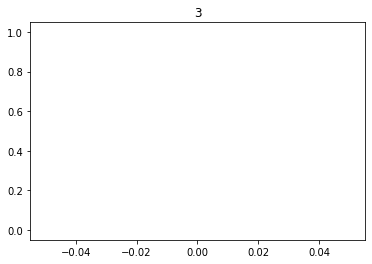

In [ ]:
pulses_icp = pulses_icp.detach().cpu().numpy()
pulses_icp = [arr for arr in pulses_icp] 
for idp, pulse in enumerate(pulses_icp):
    f = plt.figure()
    plt.plot(pulse)
    # plt.title(predictions_icp[idp])
    plt.show()

In [ ]:
print(type(pulses_icp))         # list? ndarray? tensor?
print(type(pulses_icp[0])) 

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(np.unique(predictions_abp, return_counts=True))